## Imports

In [1]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

## Load Dataset

In [2]:
(train_examples, validation_examples), info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

In [3]:
num_examples = info.splits['train'].num_examples

## Pre process and prepare Batches

In [4]:
BATCH_SIZE = 32
IMAGE_RES = 224

In [5]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

In [6]:
train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

## Transfer learning from tensorflow hub

In [7]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [8]:
feature_extractor.trainable = False

## Attach a classifier head

In [9]:
model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(5)
])

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [11]:
EPOCHS = 3

In [12]:
history = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=EPOCHS
)

Epoch 1/3
92/92 [==============================] - 7s 77ms/step - loss: 0.7500 - accuracy: 0.7221 - val_loss: 0.4453 - val_accuracy: 0.8447
Epoch 2/3
92/92 [==============================] - 4s 44ms/step - loss: 0.3737 - accuracy: 0.8757 - val_loss: 0.3636 - val_accuracy: 0.8787
Epoch 3/3
92/92 [==============================] - 4s 44ms/step - loss: 0.2929 - accuracy: 0.9040 - val_loss: 0.3224 - val_accuracy: 0.9019


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Check the predictions

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch, label_batch = image_batch.numpy(), label_batch.numpy()

In [15]:
predicted_batch = model.predict(image_batch)

For every image in the batch, we get five predictions. We have to take argmax to get the predicted class!

In [16]:
predicted_batch[:5]

array([[ 3.8878174 , -0.53414524, -3.3878243 , -0.96963567, -5.268701  ],
       [-0.89059114, -1.3548118 , -2.7977612 ,  3.5600061 , -5.7549043 ],
       [-4.7760606 , -0.68751204,  3.7908275 , -0.81346196, -2.652947  ],
       [-3.699269  ,  0.99098206, -2.801656  , -4.433952  , -4.622001  ],
       [ 1.9414731 , -2.7202082 , -1.8520048 , -5.3157926 , -3.3356795 ]],
      dtype=float32)

In [17]:
np.argmax(predicted_batch, axis=1) # Max of the class in row axis

array([0, 3, 2, 1, 0, 3, 0, 0, 0, 3, 1, 0, 1, 4, 3, 2, 3, 4, 1, 3, 4, 1,
       3, 0, 0, 0, 4, 4, 3, 4, 3, 2])

In [18]:
class_names = np.array(info.features['label'].names)
print(f"Class names are : {class_names}")

Class names are : ['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [19]:
predicted_ids = np.argmax(predicted_batch, axis=1)

predicted_class_names = class_names[predicted_ids]

In [20]:
predicted_class_names

array(['dandelion', 'sunflowers', 'tulips', 'daisy', 'dandelion',
       'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'sunflowers',
       'daisy', 'dandelion', 'daisy', 'roses', 'sunflowers', 'tulips',
       'sunflowers', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy',
       'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'roses',
       'roses', 'sunflowers', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Lets look at the true labels and the predicted labels!

In [21]:
true_labels = class_names[label_batch]
predicted_labels = predicted_class_names

In [22]:
true_labels

array(['dandelion', 'sunflowers', 'tulips', 'daisy', 'dandelion',
       'sunflowers', 'daisy', 'dandelion', 'dandelion', 'sunflowers',
       'daisy', 'tulips', 'daisy', 'roses', 'sunflowers', 'tulips',
       'roses', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy',
       'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'roses',
       'roses', 'sunflowers', 'roses', 'sunflowers', 'dandelion'],
      dtype='<U10')

In [23]:
predicted_labels

array(['dandelion', 'sunflowers', 'tulips', 'daisy', 'dandelion',
       'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'sunflowers',
       'daisy', 'dandelion', 'daisy', 'roses', 'sunflowers', 'tulips',
       'sunflowers', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy',
       'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'roses',
       'roses', 'sunflowers', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

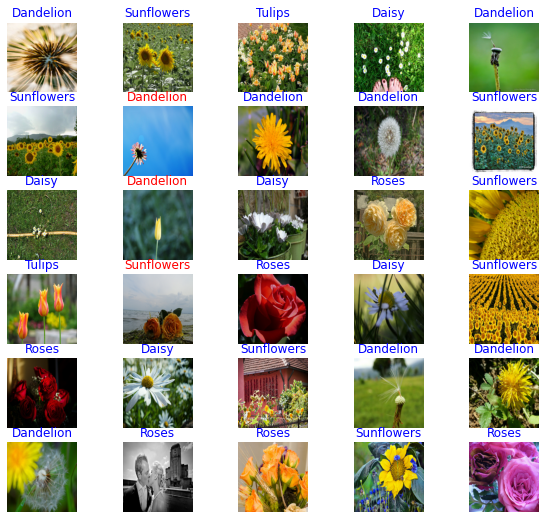

In [24]:
plt.figure(figsize=(10, 9))
for ind in range(30):
  plt.subplot(6, 5, ind + 1)
  color = "blue" if predicted_labels[ind] == true_labels[ind] else "red"
  plt.imshow(image_batch[ind])
  plt.title(predicted_class_names[ind].title(), color=color)
  plt.axis('off')

## Save as HDF5 keras model

In [25]:
t = time.time()

export_path_keras = f"./{t}.h5"
model.save(export_path_keras)

## Load the keras h5 model

In [26]:
reloaded = tf.keras.models.load_model(
    export_path_keras,
    custom_objects={'KerasLayer': hub.KerasLayer}
)

In [27]:
reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


compare model result with reloaded model result

In [28]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

The difference in the output should be zero as we are reloading the same model

In [29]:
abs(result_batch - reloaded_result_batch).sum()

0.0

## Export as a SavedModel

In [33]:
t = time.time()

export_path_sm = f"./{t}"

tf.saved_model.save(model, export_path_sm)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./1603628967.8696022/assets


INFO:tensorflow:Assets written to: ./1603628967.8696022/assets


## Load Saved Model

In [34]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [37]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

In [38]:
(abs(result_batch - reload_sm_result_batch)).max()

0.0

## Loading saved model as a keras model

In [39]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1603629105
INFO:tensorflow:Assets written to: ./1603629105/assets


INFO:tensorflow:Assets written to: ./1603629105/assets


In [40]:
reload_sm_keras = tf.keras.models.load_model(
    export_path_sm,
    custom_objects={'KerasLayer': hub.KerasLayer}
)

In [44]:
reload_sm_keras.layers[0].trainable = False

In [45]:
reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

In [47]:
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

## Download the model

In [49]:
!zip -r model.zip {export_path_sm}

  adding: 1603629105/ (stored 0%)
  adding: 1603629105/saved_model.pb (deflated 92%)
  adding: 1603629105/variables/ (stored 0%)
  adding: 1603629105/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1603629105/variables/variables.index (deflated 78%)
  adding: 1603629105/assets/ (stored 0%)


In [50]:
!ls

1603627191.606224.h5   1603627839.520813.h5  1603629105  sample_data
1603627795.1038907.h5  1603628967.8696022    model.zip


In [51]:
try:
  from google.colab import files
  files.download('./model.zip')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>